(optional)

In [135]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
os.chdir('/content/drive/MyDrive/ML/HW5')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [137]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import time
from sklearn.preprocessing import MinMaxScaler
from keras import models, layers
from keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm

In [138]:
data = np.load('data.npz')
label = np.load('label.npz')

In [139]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

# One-hot encoding
y_train = to_categorical(label['Y_train'])
y_val = to_categorical(label['Y_val'])

In [140]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [141]:
y_train.shape, y_val.shape

((604, 6), (152, 6))

## Model Implementation Part

### LSTM

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1, 60)             1070640   
                                                                 
 dropout_60 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 60)             29040     
                                                                 
 dropout_61 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_35 (LSTM)              (None, 60)                29040     
                                                                 
 dropout_62 (Dropout)        (None, 60)                0         
                                                                 
 dense_23 (Dense)            (None, 6)               

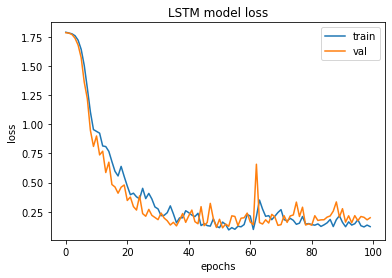

In [142]:
# Relative parameters: 
timeSteps = 1
channel = 22
timePoints = 200

# Date preprocessing (normalization, reshape): 
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train.reshape((X_train.shape[0], -1))).reshape((X_train.shape[0], 1, -1))
X_val = scaler.fit_transform(X_val.reshape((X_val.shape[0], -1))).reshape((X_val.shape[0], 1, -1))
X_test = scaler.fit_transform(X_test.reshape((X_test.shape[0], -1))).reshape((X_test.shape[0], 1, -1))

# Build your model here:
model = models.Sequential()
model.add(layers.LSTM(60, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(60, return_sequences=True))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(60))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=2)

# Plot the loss curve: 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM model loss')
plt.legend()
plt.show()

In [143]:
output = np.argmax(model.predict(X_test), axis=1).reshape((-1, 1))
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

6/6 [==============================] - 1s 6ms/step


### EEGNet

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 22, 200, 1)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 22, 200, 8)        512       
                                                                 
 batch_normalization_49 (Bat  (None, 22, 200, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_20 (Depthw  (None, 1, 200, 16)       352       
 iseConv2D)                                                      
                                                                 
 batch_normalization_50 (Bat  (None, 1, 200, 16)       64        
 chNormalization)                                                
                                                     

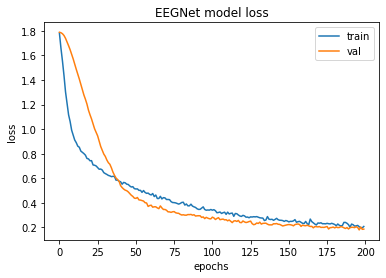

In [144]:
# Build your model here:
model = models.Sequential()
model.add(layers.Reshape((channel, timePoints, 1), input_shape=(1, channel*timePoints)))
model.add(layers.Conv2D(8, kernel_size=(1, 64), padding='same', activation='linear', 
                        use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D(kernel_size=(channel, 1), use_bias=False, 
                                 depth_multiplier=2, activation='linear', 
                                 depthwise_constraint=max_norm(1.)))

model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D(pool_size=(1, 4)))
model.add(layers.Dropout(0.5))

model.add(layers.SeparableConv2D(16, kernel_size=(1, 16), use_bias=False, padding='same', activation='linear'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D(pool_size=(1, 8)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(6, activation='softmax', kernel_constraint=max_norm(0.25)))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=2)

# Plot the loss curve: 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('EEGNet model loss')
plt.legend()
plt.show()

In [145]:
output = np.argmax(model.predict(X_test), axis=1).reshape((-1, 1))
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 46ms/step


## Model Competition Part

In [146]:
# Build your model here:

In [147]:
output = np.argmax(model.predict(X_test), axis=1).reshape((-1, 1))
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 45ms/step
